
## What is sentiment analysis?

####  Sentiment Analysis is the process of ‘computationally’ determining whether a document(sentence, phrase) is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker.

## Why sentiment analysis?

1. **Business:** In marketing field companies use it to develop their strategies, to understand customers’ feelings towards products or brand, how people respond to their campaigns or product launches and why consumers don’t buy some products
2. **Politics:** In political field, it is used to keep track of political view, to detect consistency and inconsistency between statements and actions at the government level. It can be used to predict election results as well!
3. **Public Actions:** Sentiment analysis also is used to monitor and analyse social phenomena, for the spotting of potentially dangerous situations and determining the general mood of the blogosphere.

In [16]:
!pip3 install pandas imblearn matplotlib nltk scikit-learn seaborn
!pip install "tensorflow==1.15.0"
!pip install "tensorflow_hub==0.7.0"

import warnings
warnings.filterwarnings("ignore")
from absl import logging
logging.set_verbosity(logging.ERROR)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import nltk
from gensim.models import word2vec
import time
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter


#try tunning on a GPU accelerated run time
# !pip3 install tensorflow_text==1.15
# !pip install tensorflow_text
# import tensorflow_text
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from nltk import sentiment


## The data file attached is a set of tweets

#### **Source:** https://www.kaggle.com/kazanova/sentiment140

#### Since the source file is >100MB let us try to implement this with a subset (found in data folder) 
#### Kindly extract training.1600000.processed.noemoticon.csv.zip and uncomment the lines in the next cell to execute the analysis for all the tweets(80k positive + 80k negative) 

In [17]:
# # Importing the dataset
# DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
# DATASET_ENCODING = "ISO-8859-1"
# df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
#                       encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# # Removing the unnecessary columns.
# df = df[['text','sentiment']]
# df.columns =['tweet','label'] 


tf.__version__

'1.15.0'

In [18]:
# # let us down sample this to save execution time and keep ~20k examples per target
# df = pd.concat([df[df.label==0].iloc[:20000,:],df[df.label==4].iloc[:20000,:]]).sample(frac=1).reset_index(drop=True)
# df.head(20)


In [19]:
df = pd.read_csv("/data/tweets.csv")
df.label.value_counts()

4    20000
0    20000
Name: label, dtype: int64

In [20]:
# #check if there is null values
df.isnull().sum()

#### since there are two columns '0' and '1', let us rename them to 'negative' and 'positive' respectively

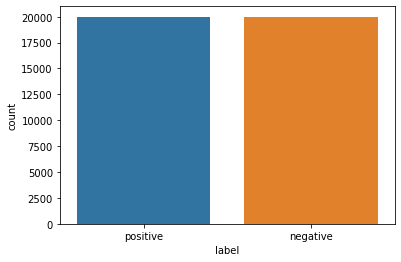

In [21]:
df.label = df.label.map({0:'negative',4:'positive'})
sns.countplot(x='label', data=df)

#### Let us call the preprocess function on the text column, to clean the text by,
1. Removing non-alphanumeric characters and replace emojis with words
2. Lowercase text
3. Stemming Words
4. Lemmatizing words to its 'lemma' form
5. Removing Stop World

In [22]:
# nltk.download('stopwords')
# all_stopwords = stopwords.words('english')
# all_stopwords.remove('not')
stemmer = PorterStemmer()
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def preprocess(text):
    text = text.split()
    text = [word if word not in emojis.keys() else emojis[word] for word in text]
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower()
    return text

In [23]:
df['tweet'] = df['tweet'].map(preprocess)

In [24]:
# X_train = df[df.split=='train'].tweet.tolist()
# y_train = df[df.split=='train'].label.tolist()

X_train, X_test, y_train, y_test = train_test_split(df["tweet"], df["label"],
                                                    stratify=df["label"],
                                                    train_size=0.8,
                                                    random_state=22)

# X_test = df[df.split=='test'].tweet.tolist()
# y_test = df[df.split=='test'].label.tolist()


## Let us try out the following techniques to analyze the sentiment in these tweets
1. Universal Sentence Encoder with SVM Gaussian
2. Universal Sentence Encoder with Naive Bayes
3. TFIDF with SVM Gaussian
4. TFIDF with Naive Bayes

## Universal Sentence Encoder
#### source : https://aclanthology.org/D18-2029/
#### hub : https://tfhub.dev/google/collections/universal-sentence-encoder/1 

In [25]:
## Load USE
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module('https://tfhub.dev/google/universal-sentence-encoder/2')

with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        X_train_use = session.run(embed(X_train))
        X_test_use = session.run(embed(X_test))


# with tf.device('/gpu:0'):
#           train_embed = embed(X_train)
#           test_embeds = embed(X_test)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [26]:
# oversample = SMOTE()
# X_train_use, y_train_use = oversample.fit_resample(X_train_use, y_train)
# summarize the new class distribution
# counter = Counter(y_train_use)
# print(counter)

In [27]:
np.shape(X_train_use)

(32000, 512)

In [28]:
svclassifier = SVC(kernel='rbf',C=5,gamma=5,class_weight = 'balanced') #Call the classifier method
svclassifier.fit(X_train_use, y_train) #Fit the model on the training data
y_pred = svclassifier.predict(X_test_use) #Predict on the test inputs

print("***** SVM GAUSSIAN KERNEL WITH UNIVERSAL SENTENCE ENCODER RESULTS *****")
print("Accuracy : ",accuracy_score(y_pred,y_test))
print("Classification Report: ",classification_report(y_pred,y_test))
print("Confusion Matrix: ",confusion_matrix(y_pred,y_test))

***** SVM GAUSSIAN KERNEL WITH UNIVERSAL SENTENCE ENCODER RESULTS *****
Accuracy :  0.759
Classification Report:                precision    recall  f1-score   support

    negative       0.75      0.76      0.76      3938
    positive       0.77      0.76      0.76      4062

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000

Confusion Matrix:  [[3005  933]
 [ 995 3067]]


#### now let us try to put the sentence embeddings through a Naive Bayes Gaussian Classifier

In [29]:
nb = GaussianNB() #Call the classifier method
nb.fit(X_train_use, y_train) #Fit the model on the training data
y_pred = nb.predict(X_test_use) #Predict on the test inputs

print("***** GAUSSIAN NB WITH UNIVERSAL SENTENCE ENCODER RESULTS *****")
print("Accuracy : ",accuracy_score(y_pred,y_test))
print("Classification Report: ",classification_report(y_pred,y_test))
print("Confusion Matrix: ",confusion_matrix(y_pred,y_test))

***** GAUSSIAN NB WITH UNIVERSAL SENTENCE ENCODER RESULTS *****
Accuracy :  0.710875
Classification Report:                precision    recall  f1-score   support

    negative       0.69      0.72      0.70      3809
    positive       0.73      0.70      0.72      4191

    accuracy                           0.71      8000
   macro avg       0.71      0.71      0.71      8000
weighted avg       0.71      0.71      0.71      8000

Confusion Matrix:  [[2748 1061]
 [1252 2939]]


#### So far, we were able to achieve the best overall f1 score with the SVM classifier.
#### We could try comparing these results against a few word embedding techniques to see, if using sentence embeddings outperform them

## Now let us see how word embeddings perform 
## We could go with word2vec to embed these tweets
### We shall average word2vec embeddings for each work in a tweet to get the embedding for a whole sentence

In [11]:
w2v_model = word2vec.Word2Vec(X_train, size=256, min_count=1, iter=50) 
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

w2vX_train = averaged_word_vectorizer(corpus=X_train, model=w2v_model,
                                             num_features = 256)
w2vX_test = averaged_word_vectorizer(corpus=X_test, model=w2v_model,
                                             num_features = 256)

In [13]:

svclassifier = SVC(kernel='rbf',C=5,gamma=5,class_weight = 'balanced') #Call the classifier method
svclassifier.fit(w2vX_train, y_train) #Fit the model on the training data
y_pred = svclassifier.predict(w2vX_test) #Predict on the test inputs

print("***** SVM GAUSSIAN KERNEL WITH TFIDF RESULTS *****")
print("Accuracy : ",accuracy_score(y_pred,y_test))
print("Classification Report: ",classification_report(y_pred,y_test))
print("Confusion Matrix: ",confusion_matrix(y_pred,y_test))

***** SVM GAUSSIAN KERNEL WITH TFIDF RESULTS *****
Accuracy :  0.587
Classification Report:                precision    recall  f1-score   support

    negative       0.62      0.58      0.60      4228
    positive       0.56      0.59      0.57      3772

    accuracy                           0.59      8000
   macro avg       0.59      0.59      0.59      8000
weighted avg       0.59      0.59      0.59      8000

Confusion Matrix:  [[2462 1766]
 [1538 2234]]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
nb = GaussianNB()
nb.fit(w2vX_train, y_train) #Fit the model on the training data
y_pred = nb.predict(w2vX_test) #Predict on the test inputs

print("*****GAUSSIAN NB KERNEL WITH TFIDF RESULTS *****")
print("Accuracy : ",accuracy_score(y_pred,y_test))
print("Classification Report: ",classification_report(y_pred,y_test))
print("Confusion Matrix: ",confusion_matrix(y_pred,y_test))

*****GAUSSIAN NB KERNEL WITH TFIDF RESULTS *****
Accuracy :  0.53775
Classification Report:                precision    recall  f1-score   support

    negative       0.69      0.53      0.60      5196
    positive       0.39      0.55      0.46      2804

    accuracy                           0.54      8000
   macro avg       0.54      0.54      0.53      8000
weighted avg       0.58      0.54      0.55      8000

Confusion Matrix:  [[2749 2447]
 [1251 1553]]


### Conclusion

### Further works:

1. To improve the performance, we could use more features like Textblob sentence polarity.
2. Word2Vec offers features like Negative Emotionality, that could be added in as feature.
3. Try out other word embedding techniques and/or frequency based technique like the TFIDF and count vectorizer